## Import the libraries

In [1]:
!pip install -q tensorflow-model-optimization

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
import keras.utils
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

import itertools

import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Loading the Data

In [3]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


## Data Preprocessing

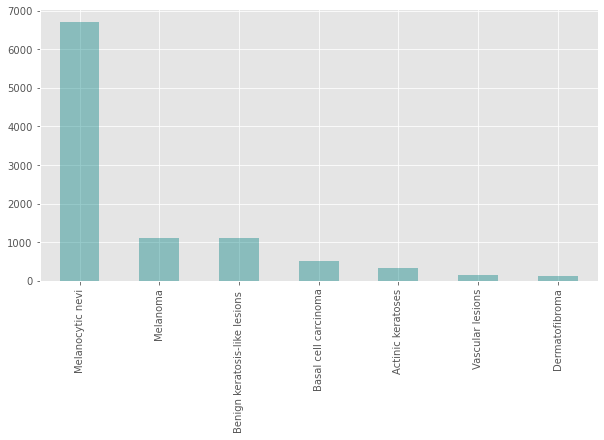

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1, color='teal', alpha=0.4)

We can see that the dataset is highly imbalanced. The number of images for Melanocytic Levi is much more than those for the other classes. So let's resample/upsample each class to 7000 instances. The code below returns a balanced dataset, in which each class has 7000 instances. Of course this leads to heavily redundant data in categories with originally very few instances.

In [6]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=7000,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

Rescaling the images to (128,128,3) and standardizing (division by 255)

In [7]:
%%time

def load_img_data(size, df, balanced=False):
    #first we should normalize the image from 0-255 to 0-1
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)
    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████| 10015/10015 [02:18<00:00, 72.56it/s]


(10015, 128, 128, 3)
CPU times: user 1min 35s, sys: 5.12 s, total: 1min 40s
Wall time: 2min 18s


## Building The model

In [8]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

[(9514, 128, 128, 3), (501, 128, 128, 3), (2003, 128, 128, 3)]

From the various different architectures mentioned Densenet201 worked best.
The training is done in 2 phases:

* Phase 1: 
           Only the new dense layers added on top of the base model is trained and the base model's layers
           remain frozen. This makes the output of the CNN convolutions remain stable and allows the dense
           layers to learn to classify the extracted features to classes.
          
* Phase 2: 
           Here we additionally fine tune the the entire model to further increase the predictive accuracy
           of the network. A lower learning rate is used to prevent too drastic changes to the feature extracters.
         
If the full CNN would be trained immediately, i.e. skipping phase 1, the completely untrained dense
layers would initially create close-to-random predictions leading to a high loss. This loss would
then be back-propagated through the whole CNN and likely “break” the already well-trained feature detectors.

         
* In phase 2 we can also train selected layers of the base model but training the entire model resulted better. 
* Data augmentation did not result in better results probably because of already upsampled data. So there was no
  need, and in fact this resulted in better acc.    
* Custom weights for different classes was tried but resulted in weaker training progress so it has been
  commented out.

In [9]:
class Tuner(object):

    def __init__(self, data, architecture, hidden_layers, classes, epochs, batch_size):
        self.input_shape = data[0][0].shape

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.hidden_layers = hidden_layers
        
        self.classes = classes

        self.trainX = data[0]
        self.trainY = data[1]
        self.valX = data[2]
        self.valY = data[3]
        self.testX = data[4]
        self.testY = data[5]

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        
        self.model = self.build()
        self.train_generator = self.data_augmentation()
        self.predictions = None
        self.score = None

        self.best_weights = None
        
    def download_network(self):
        #Download the requested CNN with imagenet weights

        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, 
                                             input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, 
                                             input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, 
                                                   input_shape=self.input_shape)
        elif self.base_arch == 'Xception':
            nn = tf.keras.applications.Xception(weights='imagenet', include_top=False, 
                                                input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, 
                                                   input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, 
                                                   input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, 
                                                   input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, 
                                                 input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, 
                                                   input_shape=self.input_shape)
        elif self.base_arch == 'EfficientNetB5':
            nn = tf.keras.applications.EfficientNetB5(weights='imagenet', include_top=False, 
                                                   input_shape=self.input_shape)

        return nn
    
    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()
        #self.load_weights(self.best_weights)
        #self.predict()
        
    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        
        for layer in self.hidden_layers:
            model.add(tf.keras.layers.Dense(layer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(0.46))  

        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        
        print (model.summary())

        return model
    
    def load_weights(self, name):
        #Load the best checkpointed weights.
        
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)
        
    def data_augmentation(self):
        data_gen_args = dict(
                rotation_range=10,
                zoom_range=0.1,
                shear_range=0.1,
                width_shift_range=0.1, 
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=True,
            )

        train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
        train_generator = train_gen.flow(self.trainX, self.trainY, batch_size=self.BATCH_SIZE)

        #print('\nData augmentation with the following parameters:')
        #pp.pprint(data_gen_args)

        return train_generator
    
    
    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        numTrainingSamples = self.trainX.shape[0]
        numValidationSamples = self.valX.shape[0]

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', 
                           optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                           metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = [tfmot.sparsity.keras.UpdatePruningStep(), 
                      tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", 
                                                         mode="min", save_best_only=True, verbose=1)]

        
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=checkpoint)
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph A')
        
        print ("\nPhase B  - Fine Tune all Layers \n")
        # Set full original CNN as trainable
        self.nn.trainable = True

        self.model.compile(loss='sparse_categorical_crossentropy', 
                           optimizer=tf.keras.optimizers.Adam(lr=1e-5), 
                           metrics=['accuracy'])
        
        # Define checkpoint to save best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = [tfmot.sparsity.keras.UpdatePruningStep(), 
                      tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", 
                                                         save_best_only=True, verbose=1)]


        # Fine-tune the full CNN + FC
        history = self.model.fit(
            x_train, y_train,
            #self.train_generator,
            steps_per_epoch=numTrainingSamples // self.BATCH_SIZE,
            epochs=self.EPOCHS,
            validation_data=(self.valX, self.valY),
            validation_steps=numValidationSamples // self.BATCH_SIZE,
            #class_weight=self.get_class_weight(),
            callbacks=checkpoint)
        
        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
        # restore best phase 2 weights and update Tuner predictions.
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, '\n Transfer Learning: ' + self.base_arch + ' Ph B')
        
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.testX, self.testY, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.testX, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()


9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               10486272  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
___________________________________________________________

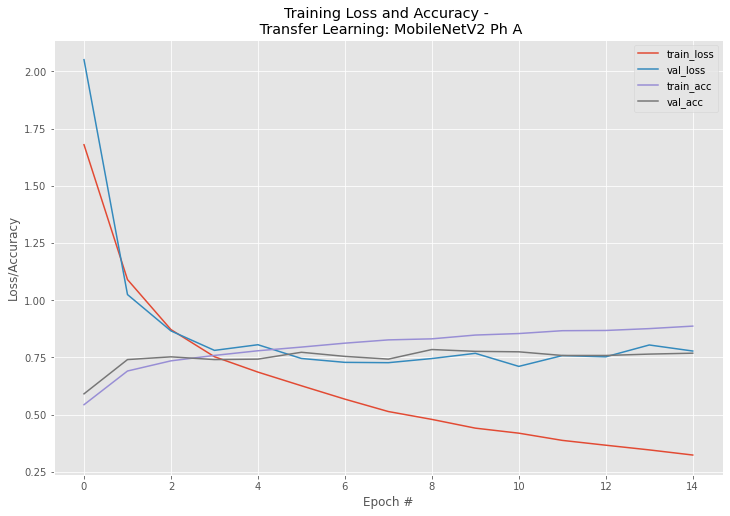


Phase B  - Fine Tune all Layers 

Epoch 1/15
74/74 [==============================] - ETA: 0s - loss: 1.6929 - accuracy: 0.6117
Epoch 00001: val_loss improved from inf to 0.97343, saving model to MobileNetV2_ph2_weights.hdf5
74/74 [==============================] - 16s 214ms/step - loss: 1.6929 - accuracy: 0.6117 - val_loss: 0.9734 - val_accuracy: 0.7445
Epoch 2/15
74/74 [==============================] - ETA: 0s - loss: 1.2942 - accuracy: 0.6779
Epoch 00002: val_loss did not improve from 0.97343
74/74 [==============================] - 14s 192ms/step - loss: 1.2942 - accuracy: 0.6779 - val_loss: 1.1346 - val_accuracy: 0.7166
Epoch 3/15
74/74 [==============================] - ETA: 0s - loss: 1.1092 - accuracy: 0.7029
Epoch 00003: val_loss did not improve from 0.97343
74/74 [==============================] - 14s 188ms/step - loss: 1.1092 - accuracy: 0.7029 - val_loss: 1.2609 - val_accuracy: 0.7166
Epoch 4/15
74/74 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0

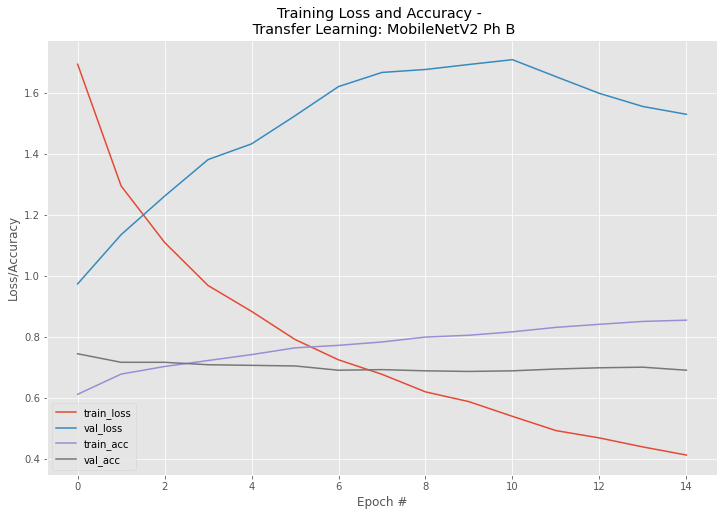

CPU times: user 3min 17s, sys: 1min 8s, total: 4min 25s
Wall time: 5min


In [10]:
%%time
NET = 'ResNet152V2'
HIDDEN_LAYERS = [512, 128]
#HIDDEN_LAYERS = [256, 256, 64]
CLASSES = len(set(target))
BATCH_SIZE = 128
EPOCHS = 15

crmodel = Tuner(train_val_test, NET, HIDDEN_LAYERS, CLASSES, EPOCHS, BATCH_SIZE)
crmodel.run()

In [11]:
crmodel.predict()


Predicting test set classes.
Test set score: [1.5120474100112915, 0.6974537968635559]
Done


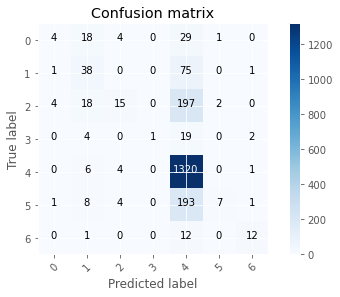

In [12]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Predict the values from the validation dataset
Y_pred = crmodel.predictions
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

## Pruning, Quantizing and Converting to Tflite model

In [13]:
model_for_export = tfmot.sparsity.keras.strip_pruning(crmodel.model)
converter =tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()
open("pruned_tflite_model.tflite", "wb").write(pruned_tflite_model)

51086808

In [14]:
converter1 =tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter1.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter1.convert()
open("quant_tflite_model.tflite", "wb").write(quant_tflite_model)

12878496

## Checking the tflite model

In [15]:
pruned_tflite_model_file = 'pruned_tflite_model.tflite'

In [16]:
pruned_interpreter = tf.lite.Interpreter(model_path=str(pruned_tflite_model_file))
pruned_interpreter.allocate_tensors()

In [17]:
quant_tflite_model_file='quant_tflite_model.tflite'
quant_interpreter = tf.lite.Interpreter(model_path=str(quant_tflite_model_file))
quant_interpreter.allocate_tensors()

This is not the metric that is used for actual accuracy estimation.
This is done just to check if quantization of the tflite model reduces accuracy.
If yes, then how much?
If no, then gg.

In [18]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in x_test:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == y_test[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [19]:
print(evaluate_model(pruned_interpreter))

0.6974538192710934


In [20]:
print(evaluate_model(quant_interpreter))

0.6864702945581628
